# Settings

In [ ]:
!nvidia-smi

Sun Jun 26 14:58:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 必要なライブラリのインストール

In [ ]:
!pip download timm
!pip uninstall albumentations -y
!pip install albumentations -Uq
!pip install timm -Uq
!pip install opencv-python-headless==4.1.2.30

Found existing installation: albumentations 0.1.12
Uninstalling albumentations-0.1.12:
  Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 113 kB 5.1 MB/s 
     |████████████████████████████████| 48.3 MB 216 kB/s 


In [ ]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import math
import time
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from datetime import datetime
from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Model
import timm
# import lightly

# TTA
# import ttach as tta

# Config

In [ ]:
class CFG:
  def __init__(self):

      self.wandb = False
      self.debug = False
      self.early_stop_flg = True
      self.early_stop_round = 4
      self.exp_name = '023_exp'
      self.seed = 55
      self.n_fold = 5
      self.num_workers = 1
      self.model_name = 'vit_large_patch16_384'
      self.mode = 'Classification'
      self.padding = False
      self.multitask = False
      self.SSL = False
      self.size = 384
      self.fold = [0,1,2,3,4]

      self.epochs = 10
      self.batch_size = 2
      self.lr = 1e-5
      self.weight_decay = 1e-6
      self.scheduler = 'scheduler:CosineAneelingLR'
      self.eta_min = 0
      self.T_max = self.epochs
      self.MIXUP = False
      self.TTA = False
      self.alpha = 1.0
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      self.n_tta = 10
      self.accumulation_steps = 8
      self.N_MSD = 5

CONFIG = CFG()

# W&B

In [ ]:
!pip install wandb -Uq

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 75.7 MB/s 
     |████████████████████████████████| 145 kB 75.4 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


In [ ]:
import wandb

config_dict = {key: value for key,value in CONFIG.__dict__.items()}

if CONFIG.wandb==True:
    wandb.init(project='nihonga', 
               entity='sk2',
               name = CONFIG.exp_name)
    wandb.config.update(config_dict)

In [ ]:
def seed_everything(seed:int==42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CONFIG.seed)

# Data Load

In [ ]:
INPUT_DIR = "/content/drive/MyDrive/nihonga/data/"

EXP_NAME = f'{CONFIG.exp_name}'
OUTPUT_DIR = f'/content/drive/MyDrive/nihonga/interim/{EXP_NAME}/'
MODEL_DIR = f'/content/drive/MyDrive/nihonga/model/{EXP_NAME}/'
OOF_DIR = f'/content/drive/MyDrive/nihonga/oof/{EXP_NAME}/'
SUB_DIR = f'/content/drive/MyDrive/nihonga/sub/{EXP_NAME}/'

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OOF_DIR, exist_ok=True)
os.makedirs(SUB_DIR, exist_ok=True)

print(f'INPUT_DIR: {INPUT_DIR}')
print(f'OUTPUT_DIR: {OUTPUT_DIR}')
print(f'MODEL_DIR: {MODEL_DIR}')
print(f'OOF_DIR: {OOF_DIR}')
print(f'SUB_DIR: {SUB_DIR}')

INPUT_DIR: /content/drive/MyDrive/nihonga/data/
OUTPUT_DIR: /content/drive/MyDrive/nihonga/interim/023_exp/
MODEL_DIR: /content/drive/MyDrive/nihonga/model/023_exp/
OOF_DIR: /content/drive/MyDrive/nihonga/oof/023_exp/
SUB_DIR: /content/drive/MyDrive/nihonga/sub/023_exp/


In [ ]:
for i, file in enumerate(glob.glob(os.path.join(INPUT_DIR, '*'))):

    print(i,file)

0 /content/drive/MyDrive/nihonga/data/submission.csv
1 /content/drive/MyDrive/nihonga/data/test_data.npz
2 /content/drive/MyDrive/nihonga/data/train_data.npz


In [ ]:
train_img = np.load(os.path.join(INPUT_DIR,
                                'train_data.npz'))
test_img = np.load(os.path.join(INPUT_DIR,
                                'test_data.npz'))
sub_df = pd.read_csv(os.path.join(INPUT_DIR,
                                'submission.csv'))

In [ ]:
train_df = pd.DataFrame(range(6446),columns=['id'])
train_df['label'] = train_img['arr_1']
train_df.head()

,id,label
0,0,1
1,1,1
2,2,0
3,3,3
4,4,0


In [ ]:
test_df = pd.DataFrame(range(test_img['arr_0'].shape[0]),columns=['id'])
test_df.head()

,id
0,0
1,1
2,2
3,3
4,4


In [ ]:
def expand_padding(img_path) -> (np.array, np.array):

    img = Image.open(img_path)
    width, height = img.size

    left = (224 - width) // 2
    top = (224 - height) // 2

    new_img = Image.new(img.mode , (224,224) , (0,0,0))
    new_img.paste(img, (left,top))

    return np.array(img) , np.array(new_img)

In [ ]:
if CONFIG.debug:
    train_df = train_df.head(100)
    test_df = test_df.head(50)

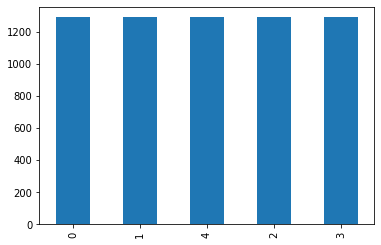

In [ ]:
train_df['fold'] = -1
strat_kfold = StratifiedKFold(n_splits=CONFIG.n_fold, random_state=CONFIG.seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['label'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [ ]:
train_df[train_df['fold']==1]['label'].value_counts()

0    603
1    440
3    123
2    123
Name: label, dtype: int64

In [ ]:
class nihongaDataset:

    def __init__(self, img, label = None, is_train = True , is_padding=True, transform=None):

        self.img = img
        self.is_train = is_train
        self.is_padding = is_padding
        self.transform = transform
        self.label = label
#        if is_train:
#          self.train_img = train_img
#        else:
#          self.train_img = test_img

    def __len__(self):
        return len(self.img)

    def __getitem__(self, item):

#        _img = self.train_img['arr_0'][item]
        _img = self.img[item]
        ##Zero Paddingするかどうか
        if self.is_padding:
          _ , _img = expand_padding(_img)

        ## Augmentationするかどうか
        if self.transform is not None:
            transformed = self.transform(image = _img)
            image = transformed['image']

        else:
            image = _img
        
        ## Train / Test
        if self.is_train:
#            target = self.train_img['arr_1'][item]
            target = self.label[item]

            return {
                'image' : torch.tensor(image, dtype=torch.float),
                'label' : torch.tensor(target, dtype=torch.float),
            }

        else:
          return {
                'image' : torch.tensor(image, dtype=torch.float),
          }

In [ ]:
from albumentations.augmentations.transforms import VerticalFlip
##Image Netの平均と分散
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def get_transforms(*, data):

    if data == 'train':
        return A.Compose([
            A.Resize(CONFIG.size, CONFIG.size, p=1),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit= 0.1, rotate_limit=15),
            A.HorizontalFlip(p=0.5),
            A.Blur(blur_limit=(3,7), p = 0.3),
            A.Rotate(always_apply=False, p=0.05, limit=(-90, 90), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
            A.HueSaturationValue(always_apply=False, p=0.3, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
            A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CONFIG.size, CONFIG.size, p=1),
            A.Normalize(mean=MEAN, std=STD),
            ToTensorV2()
        ])

    elif data == 'TTA':
        
        return A.Compose([
            A.Resize(CONFIG.size, CONFIG.size, p=1),
            #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15),
            #A.HorizontalFlip(p=0.5),
            #A.VerticalFlip(p=0.5),
            #A.Blur(blur_limit=3),
            #A.RandomBrightnessContrast(),
            #A.HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
            A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
            ToTensorV2(),
        ])

In [ ]:
## 目視で確認用
#train_dataset = nihongaDataset(img=train_df, is_train=True, is_padding=False,transform=get_transforms(data="train"))
train_dataset = nihongaDataset(img=train_img['arr_0'],label = train_img['arr_1'],  is_train=True, is_padding=False,transform=get_transforms(data="train"))
train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=CONFIG.batch_size,
            num_workers=CONFIG.num_workers,
            pin_memory=True,
            shuffle=True
            )

# 1Batch分だけ、train_loaderを回す
for data in train_loader:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


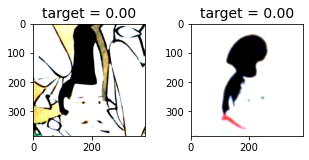

In [ ]:
## Augmentationした結果を可視化

img = data['image']
target = data['label']
img = np.array(img)
img = np.transpose(img, (0, 2, 3, 1)) # (Batch, width, height, ch)


plt.figure(figsize=(8, 7))
for i in range(2):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[i])
    plt.title(f'target = {target[i]:.2f}', fontsize=14)
plt.show()

# Model

In [ ]:
class BasicModel(nn.Module):

    def __init__(
        self, base_name,
        pretrained = True, in_channels = 3,
    ):

        """Initialize"""
        self.base_name = base_name
        super(BasicModel, self).__init__()

        # # prepare backbone
        if hasattr(timm.models, base_name):
            base_model = timm.create_model(
                base_name, num_classes = 0, pretrained = pretrained, in_chans = in_channels)
            in_features = base_model.num_features
            print('load imagenet pretrained:', pretrained)
        else:
            raise NotImplementedError

        self.base_model = base_model
        print(f"Use Model: {base_name} | Embedding Vectors: {in_features}")
        #self.layer_norm = nn.LayerNorm(in_features)
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(in_features,256)
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.3), nn.Linear(256,128)
        )
        self.fc_dropouts = nn.ModuleList([nn.Dropout(0.2) for _ in range(CONFIG.N_MSD)])
        self.head = nn.Linear(128, 4)
    def forward(self, x):
        """Forward"""
        feat = self.base_model(x)
        output_feat = self.fc1(feat)
        output_feat = self.fc2(output_feat)
        output = sum([self.head(dropout(output_feat)) for dropout in self.fc_dropouts])/CONFIG.N_MSD

        return output


# Helper Function

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target):
        target = target.float()

        # BCELossWithLogits
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
               ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size()) == 2:
            loss = loss.sum(dim=1)
        return loss.mean()

def make_one_hot(labels, C=2):
    one_hot = w(torch.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_())
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = w(Variable(target))
        
    return target

class FocalLossMultiLabel(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super().__init__()
        self.gamma = gamma
        self.nll = nn.NLLLoss(weight=weight, reduce=False)
        
    def forward(self, input, target):
        loss = self.nll(input, target)
        
        one_hot = make_one_hot(target.unsqueeze(dim=1), input.size()[1])
        inv_probs = 1 - input.exp()
        focal_weights = (inv_probs * one_hot).sum(dim=1) ** self.gamma
        loss = loss * focal_weights
        
        return loss.mean()

In [ ]:
def train_func(model, optimizer, scheduler, loss_fn, dataloader, device, epoch):

    losses = AverageMeter()

    model.train()
    tq = tqdm(dataloader, total= len(dataloader))
    sigmoid = nn.Sigmoid()
    optimizer.zero_grad()
    for step, data in enumerate(tq):

        s_t = time.time()
        optimizer.zero_grad()

        image = data['image'].to(device)
        target = data['label'].to(torch.long).to(device)
        bsz = data['label'].shape[0] # Batch Size
        preds = model(image)

        loss = loss_fn(preds, target)
        e_t = time.time() - s_t

        #loss = loss / CONFIG.accumulation_steps
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.update(loss.item(), bsz)

        if CONFIG.wandb == True:
            wandb.log({'epoch': epoch+1, 'fold': fold+1, "step_loss": loss})
            wandb.log({'epoch': epoch+1, 'fold': fold+1, "Learning Rate": optimizer.param_groups[0]["lr"]})
        
        tq.set_description(f"Train Epoch: {epoch+1:2d} | Loss{losses.avg:.5f}")

    tq.close()
    _ = gc.collect()

    return losses.avg

In [ ]:
def valid_func(model, loss_fn, dataloader, device, epoch):

    losses = AverageMeter()
    model.eval()
    tq = tqdm(dataloader, total=len(dataloader))
    valid_preds = []
    softmax = nn.Softmax()

    for step, data in enumerate(tq):

      s_t = time.time()
      image = data['image'].to(device)
      target = data['label'].to(torch.long).to(device)
      bsz = target.shape[0]

      output = model(image)
      loss = loss_fn( output, target)
      preds = softmax(output)
      preds = torch.max(preds, 1)[1]
      e_t = time.time() - s_t

      valid_preds.append(preds.detach().cpu().numpy())
      losses.update(loss.item(), bsz)
      tq.set_description(f"Valid Epoch: {epoch+1:2d} | Loss{losses.avg:.5f}")

    tq.close()
    _ = gc.collect()
    valid_preds = np.concatenate(valid_preds)

    return losses.avg, valid_preds

In [ ]:
def valid_func(model, loss_fn, dataloader, device, epoch):

    losses = AverageMeter()
    model.eval()
    tq = tqdm(dataloader, total=len(dataloader))
    valid_preds = []
    valid_probs = []
    softmax = nn.Softmax()

    for step, data in enumerate(tq):

      s_t = time.time()
      image = data['image'].to(device)
      target = data['label'].to(torch.long).to(device)
      bsz = target.shape[0]

      output = model(image)
      loss = loss_fn( output, target)
      preds = softmax(output)
      valid_probs.append(preds.detach().cpu().numpy())
      preds = torch.max(preds, 1)[1]
      e_t = time.time() - s_t

      valid_preds.append(preds.detach().cpu().numpy())
      losses.update(loss.item(), bsz)
      tq.set_description(f"Valid Epoch: {epoch+1:2d} | Loss{losses.avg:.5f}")

    tq.close()
    _ = gc.collect()
    valid_preds = np.concatenate(valid_preds)
    valid_probs = np.concatenate(valid_probs)

    return losses.avg, valid_preds, valid_probs

In [ ]:
def test_func(model, dataloader, device):

    model.eval()
    test_preds = []
    softmax = nn.Softmax()

    for data in tqdm(dataloader, total = len(dataloader)):

        image = data[('image')].to(device)
        with torch.no_grad():
            preds = model(image)
            preds = softmax(preds)

        test_preds.append(preds.detach().cpu().numpy())

    test_preds = np.concatenate(test_preds)

    return test_preds

# Train

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat, y))
from sklearn.metrics import f1_score

def get_score(y_true, y_pred):
    score = f1_score(y_true, y_pred,average='macro')
    return score

In [ ]:
CV = StratifiedKFold(n_splits=CONFIG.n_fold, shuffle=True, random_state=CONFIG.seed)

oof = np.zeros(len(train_df))
pred = np.zeros((CONFIG.n_tta, len(test_df), 4))
oof_probs = np.zeros((len(train_df), 4))
OOF = np.zeros(len(train_df))

device = CONFIG.device

for fold, (tr, va) in enumerate(CV.split(train_df,train_df['label'])):

    print(f'================================= Fold {fold+1} =================================')

    if fold in CONFIG.fold:

        tr_df = train_df.loc[tr].reset_index(drop=True)
        va_df = train_df.loc[va].reset_index(drop=True)
        tr_img = train_img['arr_0'][tr]
        va_img = train_img['arr_0'][va]
        tr_label = train_img['arr_1'][tr]
        va_label = train_img['arr_1'][va]


        train_dataset = nihongaDataset(img = tr_img,
                                       label = tr_label,
                      is_train = True,
                      is_padding = CONFIG.padding,
                      transform = get_transforms(data = 'train')
                      )


        valid_dataset = nihongaDataset(img = va_img,
                                       label = va_label,
                                    is_train = True,
                                    is_padding = CONFIG.padding,
                                    transform = get_transforms(data = 'valid')
                                    )

        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size = CONFIG.batch_size,
            num_workers = CONFIG.num_workers,
            pin_memory = True,
            shuffle = True,
        )

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size = CONFIG.batch_size,
            num_workers = CONFIG.num_workers,
            pin_memory  = True,
            shuffle = False,
        )

        base_model = BasicModel(base_name = CONFIG.model_name, pretrained = True)
        base_model.to(device)

        # 全パラメータで学習
        print(f'       All Parameter Learning ------>>>>>')

        if CONFIG.debug:
            n_epoch = 3 * len(train_loader)
        else:
            n_epoch = CONFIG.epochs * len(train_loader)

        #loss_fn = nn.BCEWithLogitsLoss()
        loss_fn = nn.CrossEntropyLoss()
        best_score = 0

        optimizer = torch.optim.AdamW(
            base_model.parameters(),
            lr = CONFIG.lr,
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max = n_epoch,
            eta_min = CONFIG.eta_min,
            last_epoch = -1,
        )

        aug_flg = True
        for epoch in range(CONFIG.epochs):

              start_time = time.time()

              #初めの数エポックと終わりの数エポックはAugmentationを掛けない
              if (epoch<=3) | (epoch>=20):
                  train_dataset = nihongaDataset(img = tr_img,
                                                label = tr_label,
                                is_train = True,
                                is_padding = CONFIG.padding,
                                transform = get_transforms(data = 'valid')
                                )
                  aug_flg = False
              else:
                  train_dataset = nihongaDataset(img = tr_img,
                                                label = tr_label,
                                is_train = True,
                                is_padding = CONFIG.padding,
                                transform = get_transforms(data = 'train')
                                )
                  aug_flg = True


              train_loader = torch.utils.data.DataLoader(
                  train_dataset,
                  batch_size = CONFIG.batch_size,
                  num_workers = CONFIG.num_workers,
                  pin_memory = True,
                  shuffle = True,
              )

              train_loss = train_func(base_model,
                                      optimizer,
                                      scheduler,
                                      loss_fn,
                                      train_loader,
                                      device,
                                      epoch
                                      )
              valid_loss, valid_preds = valid_func(base_model,
                                                  loss_fn,
                                                  valid_loader,
                                                  device,
                                                  epoch
                                                  )
              score = get_score(va_df['label'].values, valid_preds)

              if CONFIG.wandb == True:

                    wandb.log({'epoch': epoch+1, 'fold': fold+1, "train_loss": train_loss})
                    wandb.log({'epoch': epoch+1, 'fold': fold+1, "valid_loss": valid_loss})
                    wandb.log({'epoch': epoch+1, 'fold': fold+1, "valid_score": score})

              end_time = time.time() - start_time

              if score > best_score:

                  best_score = score
                  oof[va] = valid_preds

                  MODEL_PATH = f"{MODEL_DIR}{CONFIG.exp_name}_fold{fold+1}.pth"
                  torch.save(base_model.state_dict(), MODEL_PATH)

              print(f"FOLD: {fold+1} | EPOCH:{epoch+1:3d} | Aug:{aug_flg} | train_loss:{train_loss:.6f} | valid_loss:{valid_loss:.6f} | valid_score:{score:.6f} | Best: {best_score:.6f} | time:{end_time:.1f}s ")

        del train_dataset, valid_dataset, train_loader, valid_loader, valid_preds
        _ = gc.collect()

        ## Predict
        base_model.load_state_dict(torch.load(MODEL_PATH))

        test_dataset = nihongaDataset(img=test_img['arr_0'],
                                      label = None,
                                      is_train=False,
                                      is_padding=False,
                                      transform=get_transforms(data='TTA')
                                    )
        test_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=CONFIG.batch_size*2,
                                                  pin_memory=True,
                                                  shuffle=False)
        
        if CONFIG.TTA == False:
            CONFIG.n_tta = 1

        _test_preds = np.zeros((CONFIG.n_tta, len(test_df), 4))

        for n in range(CONFIG.n_tta):


            test_preds = test_func(
                base_model, 
                test_loader, 
                device,
            )
            _test_preds[n] = test_preds

        pred += _test_preds.mean(axis=0)/CONFIG.n_fold
        #oof += oof / CONFIG.n_fold
        del test_dataset, test_loader, base_model
    
    else:
        epoch = CONFIG.epochs
        print(f'Fold {fold+1} is done.')
        va_df = train_df.loc[va].reset_index(drop=True)
        va_img = train_img['arr_0'][va]
        va_label = train_img['arr_1'][va]

        base_model = BasicModel(base_name = CONFIG.model_name, pretrained = False)
        base_model.to(device)

        valid_dataset = nihongaDataset(img = va_img,
                                       label = va_label,
                                    is_train = True,
                                    is_padding = CONFIG.padding,
                                    transform = get_transforms(data = 'valid')
                                    )

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size = CONFIG.batch_size,
            num_workers = CONFIG.num_workers,
            pin_memory  = True,
            shuffle = False,
        )

        MODEL_PATH = f"{MODEL_DIR}{CONFIG.exp_name}_fold{fold+1}.pth"
        base_model.load_state_dict(torch.load(MODEL_PATH))

        loss_fn = nn.CrossEntropyLoss()

        valid_loss, valid_preds, valid_probs = valid_func(base_model,
                                            loss_fn,
                                            valid_loader,
                                            device,
                                            epoch
                                            )
        score = get_score(va_df['label'].values, valid_preds)
        oof[va] = valid_preds
        oof_probs[va] = valid_probs
        print(f"FOLD: {fold+1} | valid_loss:{valid_loss:.6f} | valid_score:{score:.6f} ")

        test_dataset = nihongaDataset(img=test_img['arr_0'],
                                      label = None,
                                      is_train=False,
                                      is_padding=False,
                                      transform=get_transforms(data='TTA')
                                    )
        test_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=CONFIG.batch_size*2,
                                                  pin_memory=True,
                                                  shuffle=False)
        
        if CONFIG.TTA == False:
            CONFIG.n_tta = 1

        _test_preds = np.zeros((CONFIG.n_tta, len(test_df), 4))

        for n in range(CONFIG.n_tta):


            test_preds = test_func(
                base_model, 
                test_loader, 
                device,
            )
            _test_preds[n] = test_preds

        pred += _test_preds.mean(axis=0)/CONFIG.n_fold
        #oof += oof / CONFIG.n_fold
        del test_dataset, test_loader, base_model

================================= Fold 1 =================================
Fold 1 is done.
load imagenet pretrained: False
Use Model: vit_large_patch16_384 | Embedding Vectors: 1024


  0%|          | 0/645 [00:00<?, ?it/s]

FOLD: 1 | valid_loss:0.461382 | valid_score:0.858336 


  0%|          | 0/500 [00:00<?, ?it/s]

================================= Fold 2 =================================
Fold 2 is done.
load imagenet pretrained: False
Use Model: vit_large_patch16_384 | Embedding Vectors: 1024


  0%|          | 0/645 [00:00<?, ?it/s]

FOLD: 2 | valid_loss:0.367853 | valid_score:0.873528 


  0%|          | 0/500 [00:00<?, ?it/s]

================================= Fold 3 =================================
Fold 3 is done.
load imagenet pretrained: False
Use Model: vit_large_patch16_384 | Embedding Vectors: 1024


  0%|          | 0/645 [00:00<?, ?it/s]

FOLD: 3 | valid_loss:0.382868 | valid_score:0.877899 


  0%|          | 0/500 [00:00<?, ?it/s]

================================= Fold 4 =================================
Fold 4 is done.
load imagenet pretrained: False
Use Model: vit_large_patch16_384 | Embedding Vectors: 1024


  0%|          | 0/645 [00:00<?, ?it/s]

FOLD: 4 | valid_loss:0.453037 | valid_score:0.862124 


  0%|          | 0/500 [00:00<?, ?it/s]

================================= Fold 5 =================================
Fold 5 is done.
load imagenet pretrained: False
Use Model: vit_large_patch16_384 | Embedding Vectors: 1024


  0%|          | 0/645 [00:00<?, ?it/s]

FOLD: 5 | valid_loss:0.406924 | valid_score:0.865770 


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print("★"*40)
total_score =get_score(train_img['arr_1'], oof)
print(f'Total CV Score: {total_score:.5f}')

if CONFIG.wandb:
  wandb.log({'CV Score': total_score})

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
Total CV Score: 0.86753


In [ ]:
if CONFIG.wandb:
    wandb.finish()

In [ ]:
oof_df = pd.DataFrame(oof_probs)
oof_df.columns = ['label_0','label_1','label_2','label_3']
oof_df = pd.concat([train_df,oof_df], axis=1)
oof_df.to_csv(os.path.join(OOF_DIR, f'{CONFIG.exp_name}_oof_preds_{total_score:.5f}.csv'), index= False)
test = pd.DataFrame(pred[0,:,:])
test.columns =['label_0','label_1','label_2','label_3']
test = pd.concat([test_df,test], axis=1)
test.to_csv(os.path.join(SUB_DIR, f'{CONFIG.exp_name}_sub_preds_{total_score:.5f}.csv'),index=False)
test.head()

,id,label_0,label_1,label_2,label_3
0,0,0.000026,0.999886,0.000005,0.000083
1,1,0.990967,0.008921,0.000062,0.000050
2,2,0.999759,0.000114,0.000083,0.000045
3,3,0.038759,0.000393,0.682495,0.278353
4,4,0.035283,0.961838,0.000132,0.002747


In [ ]:
test_pred = torch.max(torch.from_numpy(pred[n].astype(np.float32)),1)[1]

In [ ]:
oof_df = pd.DataFrame(columns={'label', 'pred'})
oof_df['label'] = train_df['label']
oof_df['pred'] = oof
oof_df.to_csv(os.path.join(OOF_DIR, f'{CONFIG.exp_name}_oof_{total_score:.5f}.csv'), index= False)

In [ ]:
sub_df['y'] = test_pred
sub_df.to_csv(os.path.join(SUB_DIR, f'{CONFIG.exp_name}_sub_{total_score:.5f}.csv'),index=False)

In [ ]:
sub_df

,id,y
0,1,1
1,2,0
2,3,0
3,4,2
4,5,1
...,...,...
1995,1996,1
1996,1997,1
1997,1998,2
1998,1999,1
